In [1]:
pip install numpy scipy pandas scikit-learn cvxpy group-lasso pysindy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 kB 4.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive # Import the drive module from google.colab

drive.mount('/content/drive', force_remount=True)  # Remount with force_remount=True
!find /content/drive/MyDrive/data



Mounted at /content/drive
/content/drive/MyDrive/data
/content/drive/MyDrive/data/openface_TD_01_Direct_Positive_run1.csv
/content/drive/MyDrive/data/openface_TD_01_Direct_Negative_run1.csv
/content/drive/MyDrive/data/openface_TD_01_Divert_Positive_run1.csv
/content/drive/MyDrive/data/openface_TD_01_Divert_Negative_run1.csv
/content/drive/MyDrive/data/openface_TD_01_Direct_Positive_run2.csv
/content/drive/MyDrive/data/openface_TD_01_Direct_Negative_run2.csv
/content/drive/MyDrive/data/openface_TD_01_Divert_Positive_run2.csv
/content/drive/MyDrive/data/openface_TD_01_Divert_Negative_run2.csv
/content/drive/MyDrive/data/openface_TD_02_Direct_Positive_run1.csv
/content/drive/MyDrive/data/openface_TD_02_Direct_Negative_run1.csv
/content/drive/MyDrive/data/openface_TD_02_Divert_Positive_run1.csv
/content/drive/MyDrive/data/openface_TD_02_Divert_Negative_run1.csv
/content/drive/MyDrive/data/openface_TD_02_Direct_Positive_run2.csv
/content/drive/MyDrive/data/openface_TD_02_Direct_Negative_run

In [9]:
#!/usr/bin/env python3
# -----------------------------------------------------------
# Dynamic hypergraph reconstruction with sliding windows
# -----------------------------------------------------------
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
import pysindy as ps
from joblib import Parallel, delayed
import os

# ─────────────── USER PARAMETERS ───────────────────────────
CSV_FILE        = '/content/drive/MyDrive/data/eeg/EEG_TD_31_EEGdata.csv'
FS              = 256.0          # [Hz]
WIN_SG, ORDER   = 13, 3          # SavGol window (odd) & polynomial order
D_MAX           = 3              # highest polynomial degree in library
THRESH_SINDY    = 0.1            # sparsity threshold λ  (STLSQ)
HEDGE_THRESH    = 0.05           # cut-off ε when mapping coefs → edges

WIN_LEN         = 1024           # samples per sliding window  (≈ 4.0 s)
STRIDE          = 256            # hop between windows       (≈ 1.0 s)
MAX_ROWS        = 3000           # cap rows per window during SINDy
N_JOBS          = -1             # joblib cores (-1 = all)
OUTDIR          = 'dyn_graphs'   # save *.txt edge lists here
os.makedirs(OUTDIR, exist_ok=True)
# ───────────────────────────────────────────────────────────

# 1 ─── READ  (T × n  →  n × T)
# 1 ─── READ  (T × n  →  n × T)
raw = pd.read_csv(
        CSV_FILE,
        header=None,
        nrows=10_000,          # keep FIRST 10 000 samples (≈ 39 s at 256 Hz)
        usecols=range(20)      # keep FIRST 20 columns (channels)
      ).values.astype(np.float64)
# drop constant / all-zero channels
tol = 1e-12
nz_mask = (np.ptp(raw, axis=0) > tol)
if (~nz_mask).any():
    dropped = np.where(~nz_mask)[0] + 1
    print(f'⚠️  Dropping constant channels (1-based): {dropped.tolist()}')
raw = raw[:, nz_mask]             # keep variable channels
raw = raw.T                       # rows = channels, cols = time
n, T_raw = raw.shape
dt = 1 / FS

# 2 ─── SAVITZKY–GOLAY smooth + derivative
half = (WIN_SG - 1) // 2
X_smooth = savgol_filter(raw, WIN_SG, ORDER, axis=1, mode='interp')
dXdt     = savgol_filter(raw, WIN_SG, ORDER, deriv=1, delta=dt,
                         axis=1, mode='interp')
# trim unreliable edges
X_smooth = X_smooth[:, half:-half]
dXdt     = dXdt[:,     half:-half]
T = X_smooth.shape[1]

# 3 ─── GLOBAL NORMALISATION
scale_X = np.mean(np.abs(X_smooth))
X = X_smooth / scale_X
Y = dXdt     / scale_X
# precompute feature library names once
feature_names = [f'x{i}' for i in range(n)]       # e.g. ['x0', …, 'x29']

library = ps.PolynomialLibrary(degree=D_MAX, include_bias=True)
dummy_row = np.zeros((1, n))          # shape (1 × n_channels)
library.fit(dummy_row)

terms = library.get_feature_names(input_features=feature_names)


# ─────────── helper to map term → indices ────────────
def indices_from_term(term_str):
    """
    '1'           -> []
    'x0'          -> [0]
    'x0^2'        -> [0, 0]
    'x1^3 x4'     -> [1, 1, 1, 4]
    """
    if term_str == '1':
        return []
    idxs = []
    for tok in term_str.split():
        base, *pow_part = tok.split('^')        # 'x3^2' -> ['x3','2']
        j = int(base[1:])                       # drop the leading 'x'
        power = int(pow_part[0]) if pow_part else 1
        idxs.extend([j] * power)
    return idxs


# ─────────── coef-to-edge conversion ────────────
def coefs_to_edges(coefs, hedge_thresh):
    edges_2, edges_3 = {}, {}
    for target in range(coefs.shape[0]):
        for coef, term in zip(coefs[target], terms):
            if abs(coef) < hedge_thresh:
                continue
            idxs = indices_from_term(term)
            if len(idxs) == 1:                      # pair
                s = frozenset((target, idxs[0]))
                edges_2[s] = max(edges_2.get(s, 0.0), abs(coef))
            elif len(idxs) == 2:                    # triad
                s = frozenset((target, *idxs))
                edges_3[s] = max(edges_3.get(s, 0.0), abs(coef))
    return edges_2, edges_3

# ─────────── per-window SINDy fit ────────────────
def fit_window(w_start):
    w_end = w_start + WIN_LEN
    Xw, Yw = X[:, w_start:w_end], Y[:, w_start:w_end]

    # sub-sample rows if necessary
    if Xw.shape[1] > MAX_ROWS:
        idx = np.linspace(0, Xw.shape[1] - 1, MAX_ROWS, dtype=int)
        Xw, Yw = Xw[:, idx], Yw[:, idx]

    optimizer = ps.STLSQ(alpha=1e-3, threshold=THRESH_SINDY)
    model = ps.SINDy(feature_library=library, optimizer=optimizer)
    model.fit(Xw.T, t=dt, x_dot=Yw.T, quiet=True)

    edges2, edges3 = coefs_to_edges(model.coefficients(), HEDGE_THRESH)
    t_mid = (w_start + w_end) / 2 * dt
    return t_mid, edges2, edges3

# 4 ─── run over sliding windows (parallel) ─────────
starts = range(0, X.shape[1] - WIN_LEN + 1, STRIDE)
print(f'⏳  Fitting {len(starts)} windows …')
results = Parallel(n_jobs=N_JOBS, verbose=5)(
              delayed(fit_window)(ws) for ws in starts)
print('    done ✔')

# 5 ─── save each window’s edge list ───────────────
def pretty_edge(e): return '{' + ','.join(map(str, sorted(e))) + '}'

for t_mid, e2, e3 in results:
    stamp = f'{t_mid:010.3f}'               # zero-padded seconds
    with open(f'{OUTDIR}/edges2_{stamp}.txt', 'w') as f2, \
         open(f'{OUTDIR}/edges3_{stamp}.txt', 'w') as f3:
        for e, w in sorted(e2.items(), key=lambda x: -x[1]):
            f2.write(f'{pretty_edge(e)} {w:.4f}\n')
        for e, w in sorted(e3.items(), key=lambda x: -x[1]):
            f3.write(f'{pretty_edge(e)} {w:.4f}\n')

print(f'  Wrote {len(results)} dynamic slices to “{OUTDIR}/”')


⚠️  Dropping constant channels (1-based): [16]
⏳  Fitting 36 windows …


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done  29 out of  36 | elapsed:  2.0min remaining:   29.2s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  2.3min finished


    done ✔
  Wrote 36 dynamic slices to “dyn_graphs/”


In [ ]:
/content/drive/MyDrive/data/eeg/EEG_TD_01_EEGdata.csv


In [8]:
#!/usr/bin/env python3
# -----------------------------------------------------------
# Dynamic hypergraph reconstruction with sliding windows
# -----------------------------------------------------------
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
import pysindy as ps
from joblib import Parallel, delayed
import os

# ─────────────── USER PARAMETERS ───────────────────────────
CSV_FILE        = '/content/drive/MyDrive/data/eeg/EEG_TD_31_EEGdata.csv'
FS              = 256.0          # [Hz]
WIN_SG, ORDER   = 13, 3          # SavGol window (odd) & polynomial order
D_MAX           = 3              # highest polynomial degree in library
THRESH_SINDY    = 0.1            # sparsity threshold λ  (STLSQ)
HEDGE_THRESH    = 0.05           # cut-off ε when mapping coefs → edges

WIN_LEN         = 1024           # samples per sliding window  (≈ 4.0 s)
STRIDE          = 256            # hop between windows       (≈ 1.0 s)
MAX_ROWS        = 3000           # cap rows per window during SINDy
N_JOBS          = -1             # joblib cores (-1 = all)
OUTDIR          = 'dyn_graphs'   # save *.txt edge lists here
os.makedirs(OUTDIR, exist_ok=True)
# ───────────────────────────────────────────────────────────

# 1 ─── READ  (T × n  →  n × T)
raw = pd.read_csv(CSV_FILE, header=None).values.astype(np.float64)
# drop constant / all-zero channels
tol = 1e-12
nz_mask = (np.ptp(raw, axis=0) > tol)
if (~nz_mask).any():
    dropped = np.where(~nz_mask)[0] + 1
    print(f'⚠️  Dropping constant channels (1-based): {dropped.tolist()}')
raw = raw[:, nz_mask]             # keep variable channels
raw = raw.T                       # rows = channels, cols = time
n, T_raw = raw.shape
dt = 1 / FS

# 2 ─── SAVITZKY–GOLAY smooth + derivative
half = (WIN_SG - 1) // 2
X_smooth = savgol_filter(raw, WIN_SG, ORDER, axis=1, mode='interp')
dXdt     = savgol_filter(raw, WIN_SG, ORDER, deriv=1, delta=dt,
                         axis=1, mode='interp')
# trim unreliable edges
X_smooth = X_smooth[:, half:-half]
dXdt     = dXdt[:,     half:-half]
T = X_smooth.shape[1]

# 3 ─── GLOBAL NORMALISATION
scale_X = np.mean(np.abs(X_smooth))
X = X_smooth / scale_X
Y = dXdt     / scale_X
# precompute feature library names once
feature_names = [f'x{i}' for i in range(n)]       # e.g. ['x0', …, 'x29']

library = ps.PolynomialLibrary(degree=D_MAX, include_bias=True)
dummy_row = np.zeros((1, n))          # shape (1 × n_channels)
library.fit(dummy_row)

terms = library.get_feature_names(input_features=feature_names)


# ─────────── helper to map term → indices ────────────
def indices_from_term(term_str):
    """
    '1'           -> []
    'x0'          -> [0]
    'x0^2'        -> [0, 0]
    'x1^3 x4'     -> [1, 1, 1, 4]
    """
    if term_str == '1':
        return []
    idxs = []
    for tok in term_str.split():
        base, *pow_part = tok.split('^')        # 'x3^2' -> ['x3','2']
        j = int(base[1:])                       # drop the leading 'x'
        power = int(pow_part[0]) if pow_part else 1
        idxs.extend([j] * power)
    return idxs


# ─────────── coef-to-edge conversion ────────────
def coefs_to_edges(coefs, hedge_thresh):
    edges_2, edges_3 = {}, {}
    for target in range(coefs.shape[0]):
        for coef, term in zip(coefs[target], terms):
            if abs(coef) < hedge_thresh:
                continue
            idxs = indices_from_term(term)
            if len(idxs) == 1:                      # pair
                s = frozenset((target, idxs[0]))
                edges_2[s] = max(edges_2.get(s, 0.0), abs(coef))
            elif len(idxs) == 2:                    # triad
                s = frozenset((target, *idxs))
                edges_3[s] = max(edges_3.get(s, 0.0), abs(coef))
    return edges_2, edges_3

# ─────────── per-window SINDy fit ────────────────
def fit_window(w_start):
    w_end = w_start + WIN_LEN
    Xw, Yw = X[:, w_start:w_end], Y[:, w_start:w_end]

    # sub-sample rows if necessary
    if Xw.shape[1] > MAX_ROWS:
        idx = np.linspace(0, Xw.shape[1] - 1, MAX_ROWS, dtype=int)
        Xw, Yw = Xw[:, idx], Yw[:, idx]

    optimizer = ps.STLSQ(alpha=1e-3, threshold=THRESH_SINDY)
    model = ps.SINDy(feature_library=library, optimizer=optimizer)
    model.fit(Xw.T, t=dt, x_dot=Yw.T, quiet=True)

    edges2, edges3 = coefs_to_edges(model.coefficients(), HEDGE_THRESH)
    t_mid = (w_start + w_end) / 2 * dt
    return t_mid, edges2, edges3

# 4 ─── run over sliding windows (parallel) ─────────
starts = range(0, X.shape[1] - WIN_LEN + 1, STRIDE)
print(f'⏳  Fitting {len(starts)} windows …')
results = Parallel(n_jobs=N_JOBS, verbose=5)(
              delayed(fit_window)(ws) for ws in starts)
print('    done ✔')

# 5 ─── save each window’s edge list ───────────────
def pretty_edge(e): return '{' + ','.join(map(str, sorted(e))) + '}'

for t_mid, e2, e3 in results:
    stamp = f'{t_mid:010.3f}'               # zero-padded seconds
    with open(f'{OUTDIR}/edges2_{stamp}.txt', 'w') as f2, \
         open(f'{OUTDIR}/edges3_{stamp}.txt', 'w') as f3:
        for e, w in sorted(e2.items(), key=lambda x: -x[1]):
            f2.write(f'{pretty_edge(e)} {w:.4f}\n')
        for e, w in sorted(e3.items(), key=lambda x: -x[1]):
            f3.write(f'{pretty_edge(e)} {w:.4f}\n')

print(f'  Wrote {len(results)} dynamic slices to “{OUTDIR}/”')


⚠️  Dropping constant channels (1-based): [16]
⏳  Fitting 536 windows …


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 16.3min


KeyboardInterrupt: 

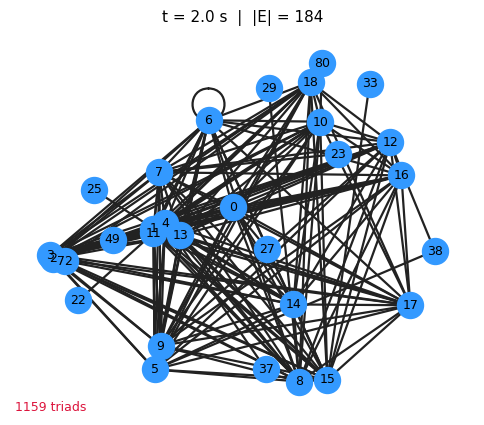

In [14]:
# Visualise dyn_graphs as an animated NetworkX movie
import os, re, glob
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

# ─── 1. load & sort the edge-list files ───────────────────────
DIR   = "dyn_graphs"               # same as OUTDIR
# 1. collect every pair file once
pair_files = sorted(glob.glob(f"{DIR}/edges2_*.txt"),
                    key=lambda s: float(re.findall(r"(\d+\.\d+)", s)[0]))

# 2. scan *all* files for node IDs
nodes = set()
for pf in pair_files:
    with open(pf) as f:
        for tok in re.findall(r"\d+", f.read()):
            nodes.add(int(tok))
nodes = sorted(nodes)

# 3. spring layout that covers everyone
G0 = nx.Graph();  G0.add_nodes_from(nodes)
pos = nx.spring_layout(G0, k=0.8, seed=1)

#pos   = {n: pos.get(n, np.random.rand(2)) for n in nodes}  # pad if needed

# ─── 2. helper: draw one frame ────────────────────────────────
def load_pairs(fname):
    G = nx.Graph()
    with open(fname) as f:
        for line in f:
            pair = [int(x) for x in re.findall(r"\d+", line)[:2]]
            G.add_edge(*pair)
    return G

tri_file = lambda p: p.replace("edges2_", "edges3_")

def draw_frame(idx):
    plt.cla()
    pfile = pair_files[idx]
    t     = float(re.findall(r"(\d+\.\d+)", pfile)[0])
    G     = load_pairs(pfile)
    nx.draw_networkx(G, pos,
                     node_color="#3399ff", node_size=350,
                     edge_color="#222222", width=1.6,
                     with_labels=True, font_size=9)
    # show triad count for info
    n_tri = sum(1 for _ in open(tri_file(pfile)))
    plt.text(0.01, 0.01, f"{n_tri} triads",
             transform=plt.gca().transAxes, fontsize=9, color='crimson')
    plt.title(f"t = {t:.1f} s  |  |E| = {G.number_of_edges()}", fontsize=11)
    plt.axis("off")

# ─── 3. animate ───────────────────────────────────────────────
fig = plt.figure(figsize=(6, 5))
anim = FuncAnimation(fig, draw_frame, frames=len(pair_files), interval=500)

# inline in Jupyter / Colab:
from IPython.display import HTML
HTML(anim.to_jshtml())

# or save as GIF:
# anim.save("dyn_graph.gif", writer=PillowWriter(fps=2))


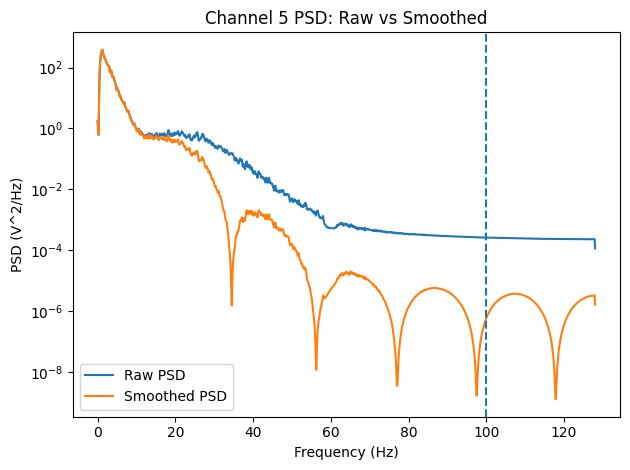

Power above 100 Hz (raw):     6.701e-03
Power above 100 Hz (smoothed): 5.407e-05
Attenuation above 100 Hz:     -20.93 dB


/tmp/ipython-input-429800979.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  power_raw_above = np.trapz(Pxx_raw[f_raw > cutoff], f_raw[f_raw > cutoff])
/tmp/ipython-input-429800979.py:40: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  power_smooth_above = np.trapz(Pxx_smooth[f_smooth > cutoff], f_smooth[f_smooth > cutoff])


In [15]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter, welch
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('/content/drive/MyDrive/data/eeg/EEG_TD_31_EEGdata.csv')
X = df.values
Fs = 256.0

# Choose a channel to analyze
channel_idx = 5
raw = X[:, channel_idx]

# Smooth the signal with SG filter (as before)
window_length = 13
polyorder = 3
smoothed = savgol_filter(raw, window_length, polyorder, axis=0)

# Compute power spectral densities
# Use Welch's method with a segment length of 2048 for good frequency resolution
f_raw, Pxx_raw = welch(raw, fs=Fs, nperseg=2048)
f_smooth, Pxx_smooth = welch(smoothed, fs=Fs, nperseg=2048)

# Plot PSDs on log scale
plt.figure()
plt.semilogy(f_raw, Pxx_raw, label='Raw PSD')
plt.semilogy(f_smooth, Pxx_smooth, label='Smoothed PSD')
plt.axvline(100, linestyle='--')  # 100 Hz cutoff line
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V^2/Hz)')
plt.title(f'Channel {channel_idx} PSD: Raw vs Smoothed')
plt.legend()
plt.tight_layout()
plt.show()

# Quantify power above 100 Hz
cutoff = 100
power_raw_above = np.trapz(Pxx_raw[f_raw > cutoff], f_raw[f_raw > cutoff])
power_smooth_above = np.trapz(Pxx_smooth[f_smooth > cutoff], f_smooth[f_smooth > cutoff])
attenuation_db = 10 * np.log10(power_smooth_above / power_raw_above)

print(f"Power above {cutoff} Hz (raw):     {power_raw_above:.3e}")
print(f"Power above {cutoff} Hz (smoothed): {power_smooth_above:.3e}")
print(f"Attenuation above {cutoff} Hz:     {attenuation_db:.2f} dB")


In [12]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter, welch
#import ace_tools as tools

# 1. Load your EEG CSV
df = pd.read_csv('/content/drive/MyDrive/data/eeg/EEG_TD_31_EEGdata.csv')
X = df.values  # shape = (184320, 31)

# 2. Define parameters
Fs = 256.0
window_length = 11   # SG window length
polyorder = 3        # SG polynomial order
cutoff = 100         # Hz threshold for high-frequency attenuation
theta_band = (4.0, 8.0)

# 3. Compute metrics for each channel
results = []
for i in range(X.shape[1]):
    raw = X[:, i]
    smoothed = savgol_filter(raw, window_length, polyorder, axis=0)

    # PSD estimation
    f_raw,   Pxx_raw    = welch(raw,    fs=Fs, nperseg=2048)
    f_smooth, Pxx_smooth = welch(smoothed,fs=Fs, nperseg=2048)

    # High-frequency attenuation
    mask_hi = f_raw > cutoff
    power_raw_hi   = np.trapz(Pxx_raw[mask_hi],    f_raw[mask_hi])
    power_smooth_hi= np.trapz(Pxx_smooth[mask_hi], f_smooth[mask_hi])
    attenuation_db = 10 * np.log10(power_smooth_hi / power_raw_hi)

    # Theta-band retention
    mask_theta = (f_raw >= theta_band[0]) & (f_raw <= theta_band[1])
    power_raw_theta    = np.trapz(Pxx_raw[mask_theta],   f_raw[mask_theta])
    power_smooth_theta = np.trapz(Pxx_smooth[mask_theta],f_smooth[mask_theta])
    retention_pct = 100 * power_smooth_theta / power_raw_theta

    results.append({
        'channel': i,
        'attenuation_dB (>100 Hz)': attenuation_db,
        'theta_retention (%)': retention_pct
    })

# 4. Display as an interactive table
df_results = pd.DataFrame(results)
print(df_results)


/tmp/ipython-input-3058225852.py:29: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  power_raw_hi   = np.trapz(Pxx_raw[mask_hi],    f_raw[mask_hi])
/tmp/ipython-input-3058225852.py:30: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  power_smooth_hi= np.trapz(Pxx_smooth[mask_hi], f_smooth[mask_hi])
/tmp/ipython-input-3058225852.py:35: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  power_raw_theta    = np.trapz(Pxx_raw[mask_theta],   f_raw[mask_theta])
/tmp/ipython-input-3058225852.py:36: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  power_smooth_theta = np.trapz(Pxx_smooth[mask_theta],f_smooth[mask_theta])
/tmp/ipython-input-30582

    channel  attenuation_dB (>100 Hz)  theta_retention (%)
0         0                -19.197298            99.820751
1         1                -19.197703            99.822307
2         2                -19.197193            99.816908
3         3                -19.196737            99.816208
4         4                -19.196093            99.813951
5         5                -19.196774            99.811892
6         6                -19.196624            99.804390
7         7                -19.196280            99.802209
8         8                -19.196585            99.805637
9         9                -19.195301            99.806466
10       10                -19.196310            99.795374
11       11                -19.195975            99.788775
12       12                -19.195379            99.789377
13       13                -19.183750            99.770792
14       14                -19.194681            99.792401
15       15                       NaN                  N

In [13]:
print(df_results.dropna().agg({
    'attenuation_dB (>100 Hz)': ['mean','std'],
    'theta_retention (%)':      ['mean','std']
}))


      attenuation_dB (>100 Hz)  theta_retention (%)
mean                -19.194374            99.775286
std                   0.002905             0.035445


In [42]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter

# 1. Load your EEG CSV (replace 'eeg_data.csv' with your file path)
df = pd.read_csv('/content/drive/MyDrive/data/eeg/EEG_TD_31_EEGdata.csv')
X = df.values  # shape = (184320, 31)

# 2. Create a time vector (since samples are equally spaced at 256 Hz)
Fs = 256.0
t = np.arange(X.shape[0]) / Fs  # shape = (184320,)

# 3. Smooth each channel and compute its time derivative with Savitzky–Golay
window_length = 11  # must be odd; ~43 ms at 256 Hz
polyorder = 3     # cubic fits

# Smooth the signal
X_smooth = savgol_filter(X, window_length, polyorder, axis=0)

# Compute the derivative
dXdt = savgol_filter(X, window_length, polyorder, deriv=1, delta=1/Fs, axis=0)

# Now X_smooth and dXdt are ready for use in SINDy or  hypergraph inference pipeline.



In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
import pysindy as ps
from itertools import combinations, permutations
from tqdm import tqdm
import math, joblib, os

# -------------------- USER PARAMETERS --------------------
CSV_FILE      = '/content/drive/MyDrive/data/eeg/EEG_TD_31_EEGdata.csv'  # rows = samples, cols = channels
FS            = 256.0     # sampling frequency [Hz]
WIN, ORDER    = 13, 3     # Savitzky–Golay window (odd) & poly-order
D_MAX         = 3         # highest polynomial degree to include
THRESH_SINDY  = 0.1       # sparsity threshold λ  (same as paper)
HEDGE_THRESH  = 0.05      # weight cutoff ε when turning coeffs → edges
# ---------------------------------------------------------

# 1. READ & ORIENT  (channels × time)
raw = pd.read_csv(CSV_FILE, header=None).values.T.astype(float)
n, T_raw = raw.shape
dt = 1 / FS

# 2. SAVITZKY–GOLAY: smooth + first derivative
half = (WIN - 1) // 2
X_smooth = savgol_filter(raw, WIN, ORDER, axis=1, mode='interp')
dXdt     = savgol_filter(raw, WIN, ORDER, deriv=1, delta=dt, axis=1, mode='interp')

# discard edge samples where SG is less reliable
X_smooth = X_smooth[:, half:-half]
dXdt     = dXdt[:,     half:-half]
T = X_smooth.shape[1]
t = np.arange(T) * dt

# 3. GLOBAL NORMALISATION
scale_X = np.mean(np.abs(X_smooth))
X       = X_smooth / scale_X
Y       = dXdt     / scale_X    # same scale factor so dx/dt units consistent

# 4. SINDy MODEL
library   = ps.PolynomialLibrary(degree=D_MAX, include_bias=True)
optimizer = ps.STLSQ(alpha=1e-3, threshold=THRESH_SINDY)
model     = ps.SINDy(feature_library=library, optimizer=optimizer)

print("  Fitting SINDy …")
model.fit(X.T, t=dt, x_dot=Y.T, quiet=True)
coefs   = model.coefficients()           # shape (n_targets, n_features)
terms   = library.get_feature_names()    # list of feature strings
print("    done ✔")

# 5. BUILD HYPERGRAPH  (pairwise + triadic only for clarity)
edges_2 = {}   # key = frozenset({i,j}),   value = weight
edges_3 = {}   # key = frozenset({i,j,k}), value = weight

def indices_from_term(term_str):
    """'x0' -> [0];  'x0 x2 x2' -> [0,2,2];  constant '1' -> []"""
    if term_str == "1":
        return []
    return [int(tok[1:]) for tok in term_str.split()]

print("🔍  Converting coefficients → hyperedges")
for target in tqdm(range(n)):
    for coef, term in zip(coefs[target], terms):
        if abs(coef) < HEDGE_THRESH:
            continue                        # not strong enough
        idxs = indices_from_term(term)
        if len(idxs) == 1:
            # pair (j → i)  →  undirected edge {i,j}
            j = idxs[0]
            s = frozenset((target, j))
            edges_2[s] = max(edges_2.get(s, 0.0), abs(coef))
        elif len(idxs) == 2:
            # triad (j,k → i)  →  undirected hyperedge {i,j,k}
            j, k = idxs
            s = frozenset((target, j, k))
            edges_3[s] = max(edges_3.get(s, 0.0), abs(coef))
        # ignore 0-order constant term and higher-order (>3) if present

print(f"   found {len(edges_2)} undirected edges and {len(edges_3)} 3-body hyperedges.")

# 6. SAVE OR PRINT RESULTS
def pretty_edge(e):
    return "{" + ",".join(map(str, sorted(e))) + "}"

with open("hypergraph_summary.txt", "w") as f:
    print("# Pairwise edges", file=f)
    for e, w in sorted(edges_2.items(), key=lambda x: -x[1]):
        print(f"{pretty_edge(e)}  weight={w:.3f}", file=f)
    print("\n# Triadic hyperedges", file=f)
    for e, w in sorted(edges_3.items(), key=lambda x: -x[1]):
        print(f"{pretty_edge(e)}  weight={w:.3f}", file=f)

print(" Wrote hypergraph_summary.txt")


⏳  Fitting SINDy …


In [9]:
from scipy.signal import welch
import numpy as np

# raw and smoothed are your 1D arrays for the chosen channel
f_raw,   Pxx_raw   = welch(raw,   fs=Fs, nperseg=2048)
f_smooth, Pxx_smooth = welch(smoothed, fs=Fs, nperseg=2048)

# define theta band
low, high = 4.0, 8.0
mask      = (f_raw >= low) & (f_raw <= high)

# integrate power in theta
power_raw_theta   = np.trapz(Pxx_raw[mask],   f_raw[mask])
power_smooth_theta= np.trapz(Pxx_smooth[mask],f_smooth[mask])

retention_pct = 100 * power_smooth_theta / power_raw_theta
print(f"Theta power retention: {retention_pct:.1f}%")


Theta power retention: 99.6%


/tmp/ipython-input-1135108909.py:13: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  power_raw_theta   = np.trapz(Pxx_raw[mask],   f_raw[mask])
/tmp/ipython-input-1135108909.py:14: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  power_smooth_theta= np.trapz(Pxx_smooth[mask],f_smooth[mask])


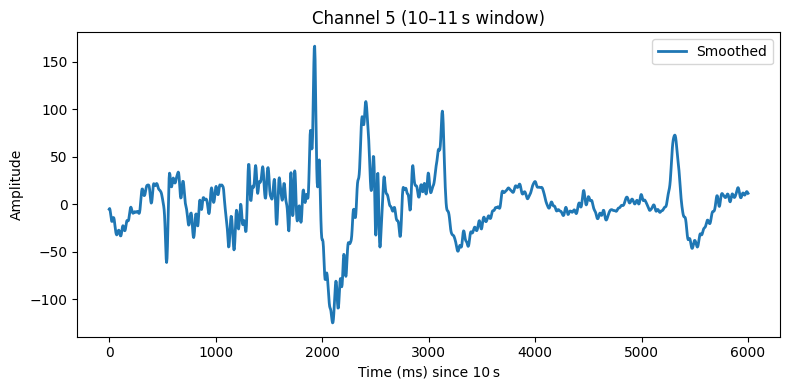

In [19]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

channel_idx = 5                  # change to your desired channel

# 4. Extract raw and smooth
raw = X[:, channel_idx]
smoothed = savgol_filter(raw, window_length=11, polyorder=3)

start, end = 5.0, 11.0
mask       = (t >= start) & (t <= end)

# 3. Plot
plt.figure(figsize=(8,4))
#plt.plot((t[mask]-start)*1000, raw[mask],    label='Raw',    alpha=0.7)
plt.plot((t[mask]-start)*1000, smoothed[mask],label='Smoothed',linewidth=2)
plt.xlabel('Time (ms) since 10 s')
plt.ylabel('Amplitude')
plt.title(f'Channel {channel_idx} (10–11 s window)')
plt.legend()
plt.tight_layout()
plt.show()

In [32]:
from sklearn.preprocessing import PolynomialFeatures

poly2 = PolynomialFeatures(degree=3, include_bias=True)
Phi2  = poly2.fit_transform(X_smooth)      # shape (K, M2)
feature_names = poly2.get_feature_names_out()


In [33]:
import pysindy as ps
sindy_pair = []

for i in range(X.shape[1]):                       # loop over nodes
    model = ps.SINDy(feature_library=ps.PolynomialLibrary(degree=2),
                     optimizer=ps.STLSQ(alpha=1e-3, threshold=1e-2))
    model.fit(X_smooth, t=t, x_dot=dXdt[:, [i]])  # fit only column i
    sindy_pair.append(model)

In [39]:
edge_weights = {}
tri_weights  = {}

for i, mdl in enumerate(sindy_pair):
    # mdl.coefficients() is shape (1, M); flatten it
    coefs = mdl.coefficients().ravel()
    fnames = mdl.get_feature_names()  # e.g. ['1', 'x0', 'x0^2', 'x0 x1', ...]

    for name, w in zip(fnames, coefs):
        if abs(w) < 1e-6 or name == '1':
            continue

        # Split on whitespace to get each variable token
        toks = name.split()  # e.g. ['x0','x1'] or ['x3^2'] or ['x0','x1','x2']

        # Extract numeric index for each tok, dropping any "^power"
        nodes = []
        for tok in toks:
            # tok starts with 'x', so strip that off
            body = tok[1:]
            # if there's a '^', drop it and everything after
            idx_str = body.split('^', 1)[0]
            nodes.append(int(idx_str))

        # Now nodes = [i,j] for an edge, or [i,j,k] for a 2‑simplex, etc.
        if len(nodes) == 2:
            edge = tuple(sorted(nodes))
            edge_weights[edge] = edge_weights.get(edge, 0.0) + w
        elif len(nodes) == 3:
            tri = tuple(sorted(nodes))
            tri_weights[tri] = tri_weights.get(tri, 0.0) + w
        # if len(nodes)==1 it's a self‑term or squared term; skip it


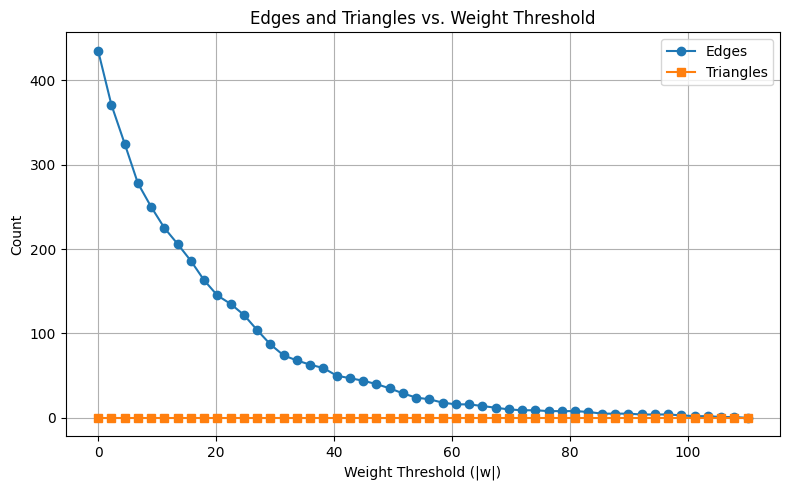

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Re-create or import your edge_weights and tri_weights dicts
# edge_weights = {...}  # (i,j) → weight
# tri_weights  = {...}  # (i,j,k) → weight

# Absolute weight arrays
edge_w = np.array([abs(w) for w in edge_weights.values()])
tri_w  = np.array([abs(w) for w in tri_weights.values()])

# Thresholds
max_w = max(edge_w.max() if edge_w.size else 0,
            tri_w.max()  if tri_w.size  else 0)
thresholds = np.linspace(0, max_w, 50)

edge_counts = [np.sum(edge_w > tau) for tau in thresholds]
tri_counts  = [np.sum(tri_w > tau)  for tau in thresholds]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(thresholds, edge_counts, label='Edges', marker='o')
plt.plot(thresholds, tri_counts,  label='Triangles', marker='s')
plt.xlabel('Weight Threshold (|w|)')
plt.ylabel('Count')
plt.title('Edges and Triangles vs. Weight Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [41]:
import numpy as np
from itertools import combinations

# assume: sindy_pair is a list of n fitted PySINDy models
#         each model was fit with PolynomialLibrary(degree=2)
#         X_smooth, dXdt, t defined as before

n = len(sindy_pair)

# 1) Extract weighted edges from the sparse coefficients
edge_weights = {}   # maps (i,j) with i<j to summed weight

for i, model in enumerate(sindy_pair):
    coefs    = model.coefficients()[0]          # shape (M,)
    features = model.get_feature_names()        # length M, e.g. ['1','x0','x0^2','x0 x1',...]

    for feat, w in zip(features, coefs):
        if ' ' in feat and abs(w) > 1e-6:
            # a cross‑term always has exactly two distinct vars in degree‑2 library
            vars_ = feat.split()                 # e.g. ['x3','x7']
            nodes = sorted(int(v[1:]) for v in vars_)
            edge  = tuple(nodes)                # (3,7)
            # accumulate (undirected) weight
            edge_weights[edge] = edge_weights.get(edge, 0.0) + w

# 2) Build adjacency matrix (optional)
W = np.zeros((n,n))
for (i,j), w in edge_weights.items():
    W[i,j] = W[j,i] = w

# 3) (Optional) Threshold to get a binary graph
tau = 2
binary_edges = [e for e,w in edge_weights.items() if abs(w)>tau]

# 4) Build 2‑simplices (triangles) from triple‑products in your degree‑3 fit
#    If you had fit degree=3, you’d similarly collect feats like 'x1 x3 x5'
#    For now, we’ll infer every triangle whose *three* pairwise edges are present:

triangles = [tuple(sorted(tri))
             for tri in combinations(range(n), 3)
             if all(tuple(sorted(edge)) in binary_edges
                    for edge in combinations(tri, 2))]

# 5) Final simplicial complex
simplicial_complex = {
    1: [(i,) for i in range(n)],     # 0‑simplices (vertices)
    2: binary_edges,                 # 1‑simplices (edges)
    3: triangles                     # 2‑simplices (filled triangles)
}

# 6) Inspect results
print(f"Found {len(binary_edges)} edges and {len(triangles)} triangles.")


Found 381 edges and 2809 triangles.


Number of edges in the graph: 147


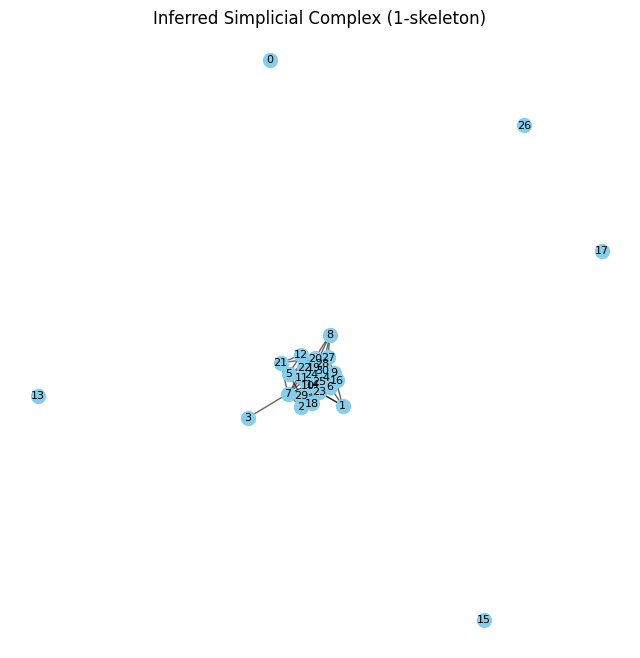

In [29]:
import networkx as nx
import matplotlib.pyplot as plt

# Assuming you have `binary_edges` from previous steps and n = 31
# Replace the following with your actual binary_edges list and node count
# For demonstration, here's a placeholder:
# binary_edges = [(i, j) for i in range(31) for j in range(i+1, 31) if some_condition]

# Example: use the previously inferred edges
# Uncomment and replace with your own:
# binary_edges = YOUR_BINARY_EDGES_LIST

# Build the graph
G = nx.Graph()
G.add_nodes_from(range(31))
G.add_edges_from(binary_edges)

# Print number of edges
print(f"Number of edges in the graph: {G.number_of_edges()}")

# Visualize the graph
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G, seed=42)  # force-directed layout
nx.draw_networkx_nodes(G, pos, node_size=100, node_color='skyblue')
nx.draw_networkx_edges(G, pos, alpha=0.6)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.title("Inferred Simplicial Complex (1-skeleton)")
plt.axis('off')
plt.show()


In [31]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1) Load coords without headers
coords_df = pd.read_csv('/content/drive/MyDrive/data/eeg/EEG_TD_31_EEGdata.csv')
coords_df.columns = ['x_LPS','y_LPS','z_LPS']

# 2) Build a pos dict using the dataframe index as channel
pos = {}
for idx, (x_lps, y_lps, z_lps) in coords_df.iterrows():
    # Montreal LPS → RAS for plotting
    x_ras = -x_lps    # L→R
    y_ras = -y_lps    # P→A
    z_ras =  z_lps    # S stays S
    pos[idx] = (x_ras, y_ras, z_ras)

# 3) Build the graph
G = nx.Graph()
G.add_nodes_from(pos.keys())
G.add_edges_from(binary_edges)  # your thresholded edge list

# 4) 3D plot
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

# Nodes
xs = [pos[i][0] for i in G.nodes()]
ys = [pos[i][1] for i in G.nodes()]
zs = [pos[i][2] for i in G.nodes()]
ax.scatter(xs, ys, zs, c='skyblue', s=80, edgecolors='k', label='Channels')

# Edges
for i,j in G.edges():
    x_line = [pos[i][0], pos[j][0]]
    y_line = [pos[i][1], pos[j][1]]
    z_line = [pos[i][2], pos[j][2]]
    ax.plot(x_line, y_line, z_line, c='gray', alpha=0.6)

# Labels
ax.set_xlabel('Right ← X → Left')
ax.set_ylabel('Anterior ← Y → Posterior')
ax.set_zlabel('Superior ↑ Z ↑ Inferior')
ax.set_title('EEG Graph in RAS Coordinates')
plt.tight_layout()
plt.show()

# 5) Summary
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")


ValueError: Length mismatch: Expected axis has 31 elements, new values have 3 elements

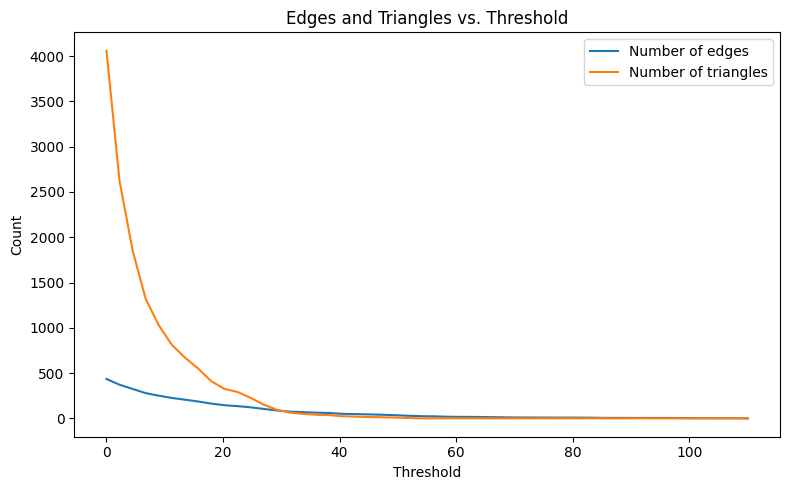

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

# Ensure you have your edge_weights dict from previous inference:
# edge_weights = {(i,j): weight, ...}
# And your number of nodes:
n = 31

# Extract absolute weights and define thresholds
weights = np.array(list(map(abs, edge_weights.values())))
thresholds = np.linspace(0, max(weights), 50)

edge_counts = []
triangle_counts = []

for tau in thresholds:
    # Binary edges at this threshold
    binary_edges = {e for e, w in edge_weights.items() if abs(w) > tau}
    edge_counts.append(len(binary_edges))

    # Count triangles by closure: all three edges must be present
    tri_count = 0
    for tri in combinations(range(n), 3):
        faces = combinations(tri, 2)
        if all(tuple(sorted(face)) in binary_edges for face in faces):
            tri_count += 1
    triangle_counts.append(tri_count)

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(thresholds, edge_counts, label='Number of edges')
plt.plot(thresholds, triangle_counts, label='Number of triangles')
plt.xlabel('Threshold')
plt.ylabel('Count')
plt.title('Edges and Triangles vs. Threshold')
plt.legend()
plt.tight_layout()
plt.show()
